In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [3]:
dt.config()

In [12]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
node_coords = S.node_coords

In [5]:
bnd_edges_idx = S.bnd_faces_indices
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

bottom_left_corner = left_bnd_nodes_idx.pop(0)

In [6]:
# UNIAXIAL TENSION TEST: prescribe horizontal displacement of the right-end nodes and fix that of the left-hand nodes.
# All the other edges are traction-free.

# Dirichlet bcs
applied_strain = 0.02
left_bnd_pos_components = [0]
right_bnd_pos_components = [0]
left_bnd_nodes_pos = S.node_coords[left_bnd_nodes_idx, :][:, left_bnd_pos_components]
right_bnd_nodes_pos = S.node_coords[right_bnd_nodes_idx, :][:, right_bnd_pos_components]*(1.+applied_strain)
bottom_left_corner_pos = S.node_coords[bottom_left_corner, :]

# NOTE: without flatten it does not work properly when concatenating multiple bcs; 
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (left_bnd_nodes_idx + right_bnd_nodes_idx, 
                         np.vstack((left_bnd_nodes_pos, right_bnd_nodes_pos)).flatten()),
                    ":": (bottom_left_corner, bottom_left_corner_pos)}

# traction bcs
idx_free_edges = list(set(bnd_edges_idx) - set(right_bnd_edges_idx) - set(left_bnd_edges_idx))
bnd_tractions_free_values = np.zeros((len(idx_free_edges), 2), dtype=dt.float_dtype)
boundary_tractions = {':': (idx_free_edges, bnd_tractions_free_values)}

In [7]:
mu_ = 1.
lambda_ = 10.
ni = lambda_/(2*(mu_ + lambda_))
E = mu_*(3*lambda_+2*mu_)/(mu_+lambda_)
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.

In [10]:
# body force
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1))).flatten()

true_strain_yy = -(lambda_/(2*mu_+lambda_))*applied_strain # plane-strain, sigma_yy = 0
true_stress_xx = (2*mu_+lambda_)*applied_strain + lambda_*true_strain_yy
print("Expected stress xx component = ", true_stress_xx)
print("Expected strain xx component = ", applied_strain)
print("Expected strain yy component = ", true_strain_yy) 

node_coords_flattened = S.node_coords.flatten()

obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 
            'boundary_tractions': boundary_tractions}

prb = optctrl.OptimizationProblem(dim=S.node_coords.size,
                                  state_dim=S.node_coords.size,
                                  objfun=ela.obj_linear_elasticity_primal)

Expected stress xx component =  0.07333333333333333
Expected strain xx component =  0.02
Expected strain yy component =  -0.016666666666666666


In [11]:
prb.set_obj_args(obj_args)
sol = prb.solve(x0=node_coords_flattened)
curr_node_coords = sol.reshape(S.node_coords.shape)
print(prb.last_opt_result)

ValueError: Incompatible shapes for broadcasting: shapes=[(66, 2), (132,)]

In [ ]:
strain = ela.get_GreenLagrange_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

In [ ]:
exact_stress = np.array([[true_stress_xx, 0.],[0.,0.]])
exact_strain = np.array([[applied_strain, 0.], [0., true_strain_yy]])
mean_stress = np.mean(stress, axis=0)
std_stress = np.std(stress,axis=0)
std_strain = np.std(strain,axis=0)
mean_strain = np.mean(strain, axis=0)
print(mean_stress) 
print(exact_stress)
print(mean_strain)
print(exact_strain)

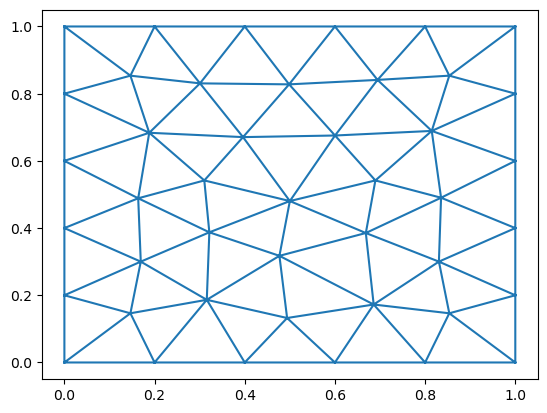

In [13]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S.S[2])
#triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [ ]:
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] *= 1 + applied_strain
true_curr_node_coords[:, 1] *= 1 + true_strain_yy

strain = ela.get_GreenLagrange_strain(true_curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

In [ ]:
print(true_curr_node_coords)
print(curr_node_coords)